"""
TODOs

* Add in profiling to time each section for tuning
    https://github.com/ipython-contrib/jupyter_contrib_nbextensions/tree/master/src/jupyter_contrib_nbextensions/nbextensions/execute_time
* ~Explode multipart features using `gdf.explode`~
* ~ Generate UTM projection automatically from dataframe ~
* ~ Buffer to fix geoms and include walking distance to roads ~
* Add option to split isochrones using voronoi
* Update env to python 3.9/not conda?
* Union isochrones with buffers around each point to catch missing road segments/walking distance
* Convert connectivity to Number and use thresholds instead of "IN" statements, since we are missing values: 
    * "speed_connectivity"  IN ('0.25','0.5','1','2','3') for low connectivity

"""

In [182]:
#!pip install geopandas rasterstats matplotlib

In [183]:
import geopandas as gpd
import pandas as pd
#import rtree # needed by geopandas for spatial indexing
from rasterstats import zonal_stats
import rtree
import pygeos

In [184]:
# For cloud
# from google.colab import drive
# drive.mount('/gdrive')
# WORK_DIR='/gdrive/My Drive/Unicef/'
# #POP_TIF = "s3://jqtrde-ona-collab/MOZ_population_v1_1_gridded_cog.tif"
WORK_DIR=''
ISOCHRONES_FILE='isochrones/kazakhstan_gov_042021_isochrone_driving_30_0.json'
#ISOCHRONES_FILE='isochrones/kz_test_isochrone_driving_30.json'
SCHOOLS_FILE='data/unicef/kazakhstan_gov_042021.json'
POP_TIF = 'data/fb/population_kaz_2018-10-01_geotiff/population_kaz_2018-10-01.tif'
# Buffer distance in UTM meters
BUFFER_DISTANCE=1
# Buffer distance around the points, to make sure we count those not on road network and to fix invalid geometry
POINT_BUFFER_DISTANCE=4000
# Not implemented -- should not be needed with buffer
SIMPLIFY=1
LIMIT=None
# Save outputs to geopackage or no
SAVE_OUTPUTS=True
# The field name in the input data to use for filtering
FILTER_FIELD='connectivity_speed'
# The cutoff value between high and medium, as a number
# no connectivity=0<LOW, Med = LOW < x < HIGH, High = X >= high
BAND_CUTOFF_HIGH=10
BAND_CUTOFF_LOW=1

In [185]:
# Load only some features for testing if Limit is defined
print("Reading input file "+ISOCHRONES_FILE)
isochrones_gdf = gpd.read_file(ISOCHRONES_FILE)[:LIMIT] if LIMIT else gpd.read_file(ISOCHRONES_FILE)

Reading input file isochrones/kazakhstan_gov_042021_isochrone_driving_30_0.json


/Users/alexyule/anaconda3/envs/geopandas/lib/python3.9/site-packages/fiona/collection.py:208: FeatureWarning: Empty field name at index 0
  self._schema = self.session.get_schema()
/Users/alexyule/anaconda3/envs/geopandas/lib/python3.9/site-packages/geopandas/geodataframe.py:577: UserWarning: Empty field name at index 0
  for feature in features_lst:


In [186]:
isochrones_gdf.head()

,,admin1,admin2,admin3,connectivity_speed,lat,lon,name,num_computers,num_computers_education,num_interactive_boards,num_students,﻿school_id,geometry
0,,Акмолинская область,Степногорск Г.А.,г.Степногорск,,52.469684,72.008278,"КГУ ""Вечерняя (сменная) средняя общеобразовате...",35,22,,60,0,"POLYGON ((72.06428 52.56996, 72.06427 52.56969..."
1,,Акмолинская область,Aршалынский район,п.Аршалы,,50.832731,72.181363,"ГУ""Вечерняя (сменная) средняя общеобразователь...",4,4,,15,1,"POLYGON ((71.70136 51.10891, 71.70118 51.10892..."
2,,Акмолинская область,Атбасарский район,г.Атбасар,,51.775718,68.340301,"ГУ ""Вечерняя (сменная) общеобразовательная сре...",7,4,,68,2,"POLYGON ((68.52630 52.09465, 68.52620 52.09382..."
3,,Акмолинская область,Жаркаинский район,г.Державинск,11,51.098673,66.314283,"ГУ ""Жаркаинская вечерняя (сменная) общеобразов...",0,0,,26,3,"POLYGON ((66.37828 51.30922, 66.37818 51.30878..."
4,,Акмолинская область,Зерендинский район,с.Гранитный,,53.434238,69.396881,"ГУ ""Вечерняя (сменная) средняя общеобразовател...",15,12,,79,4,"POLYGON ((69.39088 53.71234, 69.39072 53.71240..."


In [187]:
# Summary statistics
# TODO print stats for each category
# How many are missing connectivity data? Should really be run against the original schools table
print(f'Out of {len(isochrones_gdf)} items there are {(isochrones_gdf[FILTER_FIELD]=="").sum()} items with `{FILTER_FIELD}` blank')
#print(f'Out of {len(isochrones_gdf)} items there are {(isochrones_gdf[FILTER_FIELD]=="").sum()} items with `{FILTER_FIELD}` blank')
#print(f'Out of {len(isochrones_gdf)} items there are {(isochrones_gdf[FILTER_FIELD]=="").sum()} items with `{FILTER_FIELD}` blank')



Out of 7371 items there are 29 items with `connectivity_speed` blank


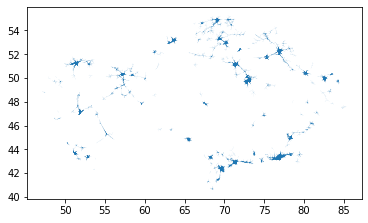

In [188]:
map=isochrones_gdf[isochrones_gdf[FILTER_FIELD]=='11'].plot()

In [189]:
# Pick the middle UTM zone
def set_utm_from_gdf(gdf):
    # DEFINE A PROJECTION HERE
    # Option 1: https://pyproj4.github.io/pyproj/stable/examples.html#find-utm-crs-by-latitude-and-longitude
    # Option 2: https://timothyrenner.github.io/talks/20171128-geo-pydata/#/transverse-mercator
    # print(box(*denmark.total_bounds))
    # https://pyproj4.github.io/pyproj/stable/api/aoi.html#pyproj.aoi.AreaOfInterest
    from pyproj.aoi import AreaOfInterest
    from pyproj.database import query_utm_crs_info
    bounds = gdf.total_bounds
    aou = AreaOfInterest(west_lon_degree=bounds[0], south_lat_degree=bounds[1], east_lon_degree=bounds[2], north_lat_degree=bounds[3])
    zones = query_utm_crs_info(area_of_interest=aou)
    middle = zones[int(len(zones)/2)]
    print("Central zone projection code: "+middle.code)
    return gdf.to_crs(epsg=middle.code)
isochrones_gdf = set_utm_from_gdf(isochrones_gdf)

Central zone projection code: 32442


In [190]:
print("Reading input points "+SCHOOLS_FILE)
points_gdf = gpd.read_file(SCHOOLS_FILE)
print("Total features: "+str(len(points_gdf)))
# project to same crs as isochrones for projection
points_buffer_gdf = points_gdf.to_crs(isochrones_gdf.crs)
points_buffer_gdf


Reading input points data/unicef/kazakhstan_gov_042021.json
Total features: 7438


,school_id,admin1,admin2,admin3,name,num_students,lat,lon,num_computers,num_computers_education,num_interactive_boards,connectivity_speed,field_13,geometry
0,0,Акмолинская область,Степногорск Г.А.,г.Степногорск,"КГУ ""Вечерняя (сменная) средняя общеобразовате...",60,52.469684,72.008278,35,22,,,,POINT (704312.056 5817531.864)
1,1,Акмолинская область,Aршалынский район,п.Аршалы,"ГУ""Вечерняя (сменная) средняя общеобразователь...",15,50.832731,72.181363,4,4,,,,POINT (723997.515 5636044.603)
2,2,Акмолинская область,Атбасарский район,г.Атбасар,"ГУ ""Вечерняя (сменная) общеобразовательная сре...",68,51.775718,68.340301,7,4,,,,POINT (454469.962 5736296.452)
3,3,Акмолинская область,Жаркаинский район,г.Державинск,"ГУ ""Жаркаинская вечерняя (сменная) общеобразов...",26,51.098673,66.314283,0,0,,11,,POINT (311943.005 5664226.347)
4,4,Акмолинская область,Зерендинский район,с.Гранитный,"ГУ ""Вечерняя (сменная) средняя общеобразовател...",79,53.434238,69.396881,15,12,,,,POINT (526351.749 5920648.002)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7433,7433,г.Шымкент,Каратауский район,,"КГУ ""Общеобразовательная средняя школа № 103""",1857,42.372352,69.712331,452,385,3,11,>10,POINT (558629.906 4691362.076)
7434,7434,г.Шымкент,Каратауский район,,"ТОО ""Начальная школа ""Жас-Дарын""",381,42.365810,69.627804,0,0,3,11,>10,POINT (551675.896 4690580.845)
7435,7435,г.Шымкент,Каратауский район,,"КГУ ""Общеобразовательная средняя школа № 131""",1861,42.313901,69.592611,461,451,4,11,>10,POINT (548818.134 4684796.280)
7436,7436,г.Шымкент,Каратауский район,,"КГУ ""Общеобразовательная средняя школа №132""",1104,42.371219,69.634382,257,222,3,11,>10,POINT (552213.025 4691185.455)


Buffering point gemetry by 4000 meters


<AxesSubplot:>

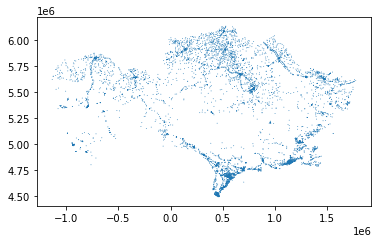

In [191]:
print(f'Buffering point gemetry by {POINT_BUFFER_DISTANCE} meters')
points_buffer_gdf.geometry = points_buffer_gdf.buffer(POINT_BUFFER_DISTANCE)
points_buffer_gdf.plot()

In [192]:
# Buffer geometries to incorporate walking time to roads and fix invalid isochrones.
print(f'Buffering isochrone geometry by {BUFFER_DISTANCE} meters')
isochrones_gdf.geometry = isochrones_gdf.geometry.buffer(BUFFER_DISTANCE)

Buffering isochrone geometry by 1 meters


<AxesSubplot:>

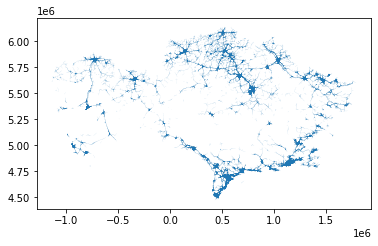

In [193]:
isochrones_gdf.plot()

In [194]:
# Append Schools to isochrones before filtering, should be a new 

In [195]:
# https://gis.stackexchange.com/questions/162659/joining-concat-list-of-similar-dataframes-in-geopandas
# Best practice to overwrite these to save memory or keep gdf immutable?
isochrones_gdf = pd.concat([isochrones_gdf, points_buffer_gdf])
isochrones_gdf

,,admin1,admin2,admin3,connectivity_speed,lat,lon,name,num_computers,num_computers_education,num_interactive_boards,num_students,﻿school_id,geometry,school_id,field_13
0,,Акмолинская область,Степногорск Г.А.,г.Степногорск,,52.469684,72.008278,"КГУ ""Вечерняя (сменная) средняя общеобразовате...",35,22,,60,0,"POLYGON ((707642.108 5828841.772, 707645.555 5...",NaN,NaN
1,,Акмолинская область,Aршалынский район,п.Аршалы,,50.832731,72.181363,"ГУ""Вечерняя (сменная) средняя общеобразователь...",4,4,,15,1,"POLYGON ((688939.591 5665376.570, 688939.523 5...",NaN,NaN
2,,Акмолинская область,Атбасарский район,г.Атбасар,,51.775718,68.340301,"ГУ ""Вечерняя (сменная) общеобразовательная сре...",7,4,,68,2,"POLYGON ((467534.533 5771668.276, 467541.128 5...",NaN,NaN
3,,Акмолинская область,Жаркаинский район,г.Державинск,11,51.098673,66.314283,"ГУ ""Жаркаинская вечерняя (сменная) общеобразов...",0,0,,26,3,"POLYGON ((317259.780 5687473.577, 317265.210 5...",NaN,NaN
4,,Акмолинская область,Зерендинский район,с.Гранитный,,53.434238,69.396881,"ГУ ""Вечерняя (сменная) средняя общеобразовател...",15,12,,79,4,"POLYGON ((525784.040 5951585.687, 525788.482 5...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7433,NaN,г.Шымкент,Каратауский район,,11,42.372352,69.712331,"КГУ ""Общеобразовательная средняя школа № 103""",452,385,3,1857,NaN,"POLYGON ((562629.906 4691362.076, 562610.645 4...",7433,>10
7434,NaN,г.Шымкент,Каратауский район,,11,42.36581,69.627804,"ТОО ""Начальная школа ""Жас-Дарын""",0,0,3,381,NaN,"POLYGON ((555675.896 4690580.845, 555656.634 4...",7434,>10
7435,NaN,г.Шымкент,Каратауский район,,11,42.313901,69.592611,"КГУ ""Общеобразовательная средняя школа № 131""",461,451,4,1861,NaN,"POLYGON ((552818.134 4684796.280, 552798.873 4...",7435,>10
7436,NaN,г.Шымкент,Каратауский район,,11,42.371219,69.634382,"КГУ ""Общеобразовательная средняя школа №132""",257,222,3,1104,NaN,"POLYGON ((556213.025 4691185.455, 556193.764 4...",7436,>10


<AxesSubplot:>

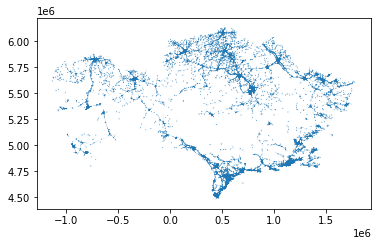

In [196]:
isochrones_gdf.plot()

In [197]:
# Convert the filter field to numeric to filter the dataset using the cutoff value above
# isochrones_gdf[FILTER_FIELD].unique()
filter_num = pd.to_numeric(isochrones_gdf[FILTER_FIELD])

In [198]:
#high = ['7','8','9','10','11']
#iso_high = isochrones_gdf[isochrones_gdf[FILTER_FIELD].isin(high)].dissolve()
iso_high = isochrones_gdf[filter_num>=BAND_CUTOFF_HIGH]
print(f'High connectivity count >= {BAND_CUTOFF_HIGH}: {len(iso_high)}')
print('Dissolving features')
iso_high = iso_high.dissolve()
#iso_high.plot()

High connectivity count >= 10: 6468
Dissolving features


No connectivity count: 188
Dissolving features


<AxesSubplot:>

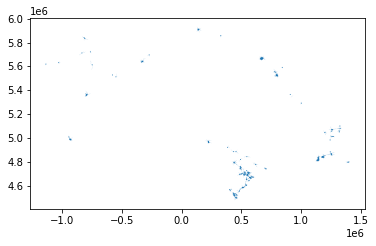

In [199]:
#low = ['0', '0.25','0.5','0.511', '0.512']
#iso_low = isochrones_gdf[isochrones_gdf[FILTER_FIELD].isin(low)].dissolve()
# Low or no connectivity is anything lower than the LOW_CUTOFF value, Kazakhstan x < 1
iso_low = isochrones_gdf[filter_num < BAND_CUTOFF_LOW]
print(f'No connectivity count: {len(iso_low)}')
print('Dissolving features')
iso_low = iso_low.dissolve()

iso_low.plot()
# new error since adding in pygeos and rtree AttributeError: 'GeoSeries' object has no attribute 'speed_connectivity'

Medium connectivity count 1 < 10: 8095
Dissolving features


<AxesSubplot:>

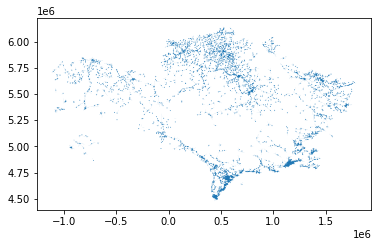

In [200]:
#med = ['4', '5', '6']
#iso_med = isochrones_gdf[isochrones_gdf[FILTER_FIELD].isin(med)].dissolve()
iso_med = isochrones_gdf[(filter_num >= BAND_CUTOFF_LOW) & (filter_num<BAND_CUTOFF_HIGH)]
print(f'Medium connectivity count {BAND_CUTOFF_LOW} < {BAND_CUTOFF_HIGH}: {len(iso_med)}')
print('Dissolving features')
iso_med = iso_med.dissolve()

# GEOSException: TopologyException: side location conflict at 80.272147453051915 42.838690953108959
iso_med.plot()

<AxesSubplot:>

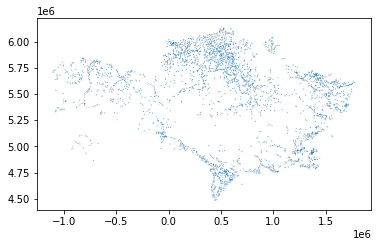

In [201]:
iso_med_only = gpd.overlay(iso_med, iso_high, how='difference')
iso_med_only.plot()

<AxesSubplot:>

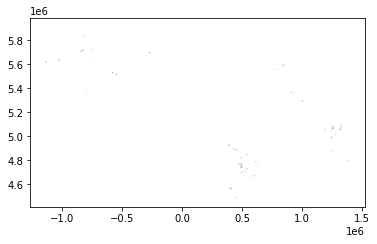

In [202]:
iso_low_only = gpd.overlay(gpd.overlay(iso_low, iso_high, how='difference'), iso_med, how='difference')
iso_low_only.plot()

In [203]:
# Calculate Areas of each feature
# https://gis.stackexchange.com/questions/218450/getting-polygon-areas-using-geopandas
area_high = iso_high.to_crs({'proj':'cea'}).geometry.area / 10**6
area_med = iso_med.to_crs({'proj':'cea'}).geometry.area / 10**6
area_low = iso_low.to_crs({'proj':'cea'}).geometry.area / 10**6
print(f'Areas: low {area_low}, med {area_med}, high {area_high}')

Areas: low 0    11276.200681
dtype: float64, med 0    180677.438917
dtype: float64, high 0    96881.163316
dtype: float64


In [204]:
iso_high_exp = iso_high.to_crs(epsg=4326).explode()
# Explode multipart features for speed increase, reproject back to lat/lon
iso_low_exp = iso_low_only.to_crs(epsg=4326).explode()
iso_med_exp = iso_med_only.to_crs(epsg=4326).explode()

In [ ]:
# Write to file for caching and tiling

if SAVE_OUTPUTS:
    print("Saving layers to file: output/output.gpkg")
    iso_med_exp.to_file('output/output.gpkg', layer='iso_med_only', driver="GPKG")
    iso_low_exp.to_file('output/output.gpkg', layer='iso_low_only', driver="GPKG")
    iso_high_exp.to_file('output/output.gpkg', layer='iso_high', driver="GPKG")

In [ ]:
print('Processing zonal stats for high connectivity')
count_high = zonal_stats(iso_high_exp, POP_TIF, stats="sum")
#IllegalArgumentException: Geometry must be a Point or LineString

In [207]:
# Add final check to avoid Nonetype is not iterable error
sum_high = sum([item['sum'] for item in count_high if item['sum']])
print(f'High connectivity population: {sum_high} density {sum_high / area_high}')

High connectivity population: 14752818.444676558 density 0    152.27747
dtype: float64


In [ ]:
count_low = zonal_stats(iso_low_exp, POP_TIF, stats="sum")
#IllegalArgumentException: Geometry must be a Point or LineString

In [209]:
sum_low = sum([item['sum'] for item in count_low if item['sum']])
print(f'Low connectivity population: {sum_low} density: {sum_low / area_low}')

Low connectivity population: 10163.23392501155 density: 0    0.901299
dtype: float64


In [ ]:
count_med = zonal_stats(iso_med_exp, POP_TIF, stats="sum")
#IllegalArgumentException: Geometry must be a Point or LineString

In [211]:
sum_med = sum([item['sum'] for item in count_med if item['sum']])
print(f'Medium connectivity population: {sum_med} density: {sum_med / area_med}')

Medium connectivity population: 1909338.562615014 density: 0    10.567665
dtype: float64
